Esse notebook tem como objetivo o desenvolvimento do terceiro modelo de behavior solicitados pela claro para avaliar se clientes pré-pago virariam ou não inadimplentes ao migrar para plano controle.
Esse modelo irá utilizar toda a base BUREAU + base TELCO disponibilizada


#BIBLIOTECAS E INSTALAÇÕES

In [ ]:
#configurando ambiente spark:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
# manipulação, leitura e vizualização de dados bibiliotecas
import pandas as pd
import matplotlib.pyplot as plt
import pandas            as pd
import seaborn           as sns
import numpy             as np

In [ ]:
# Configurar o Pandas para não usar notação científica para floats e exibir com 2 casas decimais
pd.set_option('display.float_format', '{:.6f}'.format)
pd.set_option('display.max_rows', 79)
pd.set_option('display.max_columns', 79)
#pd.reset_option('display.width')
#pd.reset_option('display.max_colwidth')

In [ ]:
#machilne learning bibliotecas
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
!pip install category_encoders
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, auc
from sklearn.linear_model import LogisticRegression
!pip install catboost
import catboost as cb
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV, SelectKBest, f_classif, SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier # Using GradientBoostingClassifier as inferred from later use
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 27.5 MB/s eta 0:00:00


#FUNÇÕES

In [ ]:
# Criar variável para metadados
# (nomes das colunas, tipos, quantidade de nulos, percentual de nulos, cardinalidade)

def generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes.astype(str), # Convert dtypes to string for sorting
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': ((dataframe.isnull().sum() / len(dataframe)) * 100).round(2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata = metadata.sort_values(by='tipo')
    metadata = metadata.reset_index(drop=True)

    return metadata

In [ ]:
# Métricas do modelo

def calculate_metrics(nm_modelo, model, X_train, y_train, X_test, y_test):
    # Fazendo predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = model.predict_proba(X_train)[:, 1]
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1

    # Calculando as métricas para o conjunto de teste
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste
    probabilities_test = model.predict_proba(X_test)[:, 1]
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [nm_modelo, nm_modelo],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precisao': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })
    return metrics_df

def plot_metrics(model, X_train, y_train, X_test, y_test, features):
    plt.figure(figsize=(15, 18))

    # Gráfico de Barras para Taxa do Evento e Importância das Variáveis
    plt.subplot(4, 2, 1)
    event_rate = y_train.mean()
    non_event_rate = 1 - event_rate
    plt.barh(['Não Evento', 'Evento'], [non_event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
    plt.xlabel('Taxa')
    plt.title('Taxa do Evento')

    plt.subplot(4, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Ordem ascendente
    indices = indices[-10:]  # Considerando apenas as 10 mais importantes
    plt.barh(features[indices], importances[indices], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Variáveis')

    # Curva ROC para Treino e Teste
    plt.subplot(4, 2, 3)
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Gráfico de Barras para Gini e KS
    plt.subplot(4, 2, 4)
    metrics = ['Índice Gini', 'Estatística KS']
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probs = model.predict_proba(X)[:, 1]
        df = pd.DataFrame({'true_labels': y, 'predicted_probs': probs})
        df = df.sort_values(by='predicted_probs', ascending=False)
        df['cumulative_true'] = df['true_labels'].cumsum() / df['true_labels'].sum()
        df['cumulative_false'] = (1 - df['true_labels']).cumsum() / (1 - df['true_labels']).sum()
        ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
        gini = 2 * auc(*roc_curve(y, probs)[:2]) - 1
        plt.bar([f'{label}\n{metric}' for metric in metrics], [gini, ks], color='skyblue')
    plt.title('Índice Gini e Estatística KS')

    # Matrizes de Confusão para Treino e Teste
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], 5):
        plt.subplot(4, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusão - {label}')

    # Histograma do Score para Treino e Teste
    plt.subplot(4, 2, 7)
    plt.hist(model.predict_proba(X_train)[:, 1], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Treino')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Treino')
    plt.legend(loc='upper right')

    plt.subplot(4, 2, 8)
    plt.hist(model.predict_proba(X_test)[:, 1], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7, label='Teste')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Teste')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_metrics(model, X_train, y_train, X_test, y_test, features):
    plt.figure(figsize=(15, 18))

    # Gráfico de Barras para Taxa do Evento e Importância das Variáveis
    plt.subplot(4, 2, 1)
    event_rate = y_train.mean()
    non_event_rate = 1 - event_rate
    plt.barh(['Não Evento', 'Evento'], [non_event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
    plt.xlabel('Taxa')
    plt.title('Taxa do Evento')

    plt.subplot(4, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Ordem ascendente
    indices = indices[-10:]  # Considerando apenas as 10 mais importantes
    plt.barh(features[indices], importances[indices], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Variáveis')

    # Curva ROC para Treino e Teste
    plt.subplot(4, 2, 3)
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Gráfico de Barras para Gini e KS
    plt.subplot(4, 2, 4)
    metrics = ['Índice Gini', 'Estatística KS']
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probs = model.predict_proba(X)[:, 1]
        df = pd.DataFrame({'true_labels': y, 'predicted_probs': probs})
        df = df.sort_values(by='predicted_probs', ascending=False)
        df['cumulative_true'] = df['true_labels'].cumsum() / df['true_labels'].sum()
        df['cumulative_false'] = (1 - df['true_labels']).cumsum() / (1 - df['true_labels']).sum()
        ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
        gini = 2 * auc(*roc_curve(y, probs)[:2]) - 1
        plt.bar([f'{label}\n{metric}' for metric in metrics], [gini, ks], color='skyblue')
    plt.title('Índice Gini e Estatística KS')

    # Matrizes de Confusão para Treino e Teste
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], 5):
        plt.subplot(4, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusão - {label}')

    # Histograma do Score para Treino e Teste
    plt.subplot(4, 2, 7)
    plt.hist(model.predict_proba(X_train)[:, 1], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Treino')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Treino')
    plt.legend(loc='upper right')

    plt.subplot(4, 2, 8)
    plt.hist(model.predict_proba(X_test)[:, 1], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7, label='Teste')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Teste')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# LEITURA E PADRONIZAÇÃO DA BASE DE DADOS

In [ ]:
import sklearn.feature_selection

# Get a list of all attributes (modules, functions, classes) in sklearn.feature_selection
available_modules = dir(sklearn.feature_selection)

# Filter out private/internal attributes and print them
print("Available modules and functions in sklearn.feature_selection:")
for item in sorted(available_modules):
    if not item.startswith('_'): # Exclude private members
        print(f"- {item}")

Available modules and functions in sklearn.feature_selection:
- GenericUnivariateSelect
- RFE
- RFECV
- SelectFdr
- SelectFpr
- SelectFromModel
- SelectFwe
- SelectKBest
- SelectPercentile
- SelectorMixin
- SequentialFeatureSelector
- VarianceThreshold
- chi2
- f_classif
- f_oneway
- f_regression
- mutual_info_classif
- mutual_info_regression
- r_regression


## base bureal

In [ ]:
#conectando com google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#lendo dataset
df_bureal = pd.read_parquet('/content/drive/MyDrive/bases_CLARO_CREDITO/base_score_bureau_movel/base_score_bureau_movel/BASECPFUNICOparquetunico/part-00000-98e88720-cfb7-4d91-aadf-a26be5bb24ce-c000.snappy.parquet')

In [ ]:
#tamanho do dataset
df_bureal.shape

(1272095, 5)

In [ ]:
#vendo 5 primeiras linhas
df_bureal.head(5)

,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02
0,ZZZZZX7XWY8,202410,0,562,636
1,ZZZZZX88YXY,202410,1,546,518
2,ZZZZZYT7XYT,202410,0,621,750
3,ZZZZZNTXY9Z,202410,1,609,679
4,ZZZZZ79ZXUX,202410,0,621,722


- O Grupo controle será removido da base do modelo uma vez que é um grupo de pessoas em que o modelo não é aplicado.
- O grupo controle pode ser identificado a partir do 6º e 7º dígitos do CPF, considerando as combinações ZZ e ZX.

In [ ]:
# Filtra o DataFrame para remover linhas onde o 6º e 7º dígitos de NUM_CPF são 'ZZ' ou 'ZX'
df_bureal_sem_grupo_controle = df_bureal[~df_bureal['NUM_CPF'].str[5:7].isin(['ZZ', 'ZX'])]

# Exibe o novo formato do DataFrame para verificar
print(f"Shape of df_bureal_sem_grupo_controle_pd (rows, columns): {df_bureal_sem_grupo_controle.shape}")
display(df_bureal_sem_grupo_controle.head())

Shape of df_bureal_sem_grupo_controle_pd (rows, columns): (1213448, 5)


,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02
0,ZZZZZX7XWY8,202410,0,562,636
1,ZZZZZX88YXY,202410,1,546,518
2,ZZZZZYT7XYT,202410,0,621,750
3,ZZZZZNTXY9Z,202410,1,609,679
4,ZZZZZ79ZXUX,202410,0,621,722


In [ ]:
#% de CPFs que pertecem ao grupo controle:
original_num_rows = 1272095
filtered_num_rows = df_bureal_sem_grupo_controle.shape[0]

control_group_count = original_num_rows - filtered_num_rows
percentage_control_group = (control_group_count / original_num_rows) * 100

print(f"CPFS que pertencem ao grupo controle: {control_group_count}")
print(f"% CPFS do grupo controle em relação ao total da base: {percentage_control_group:.2f}%")

CPFS que pertencem ao grupo controle: 58647
% CPFS do grupo controle em relação ao total da base: 4.61%


In [ ]:
#GERANDO METADADOS DA TABELA:
generate_metadata(df_bureal_sem_grupo_controle)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,NUM_CPF,object,0,0.000000,1213448
1,SAFRA,object,0,0.000000,6
2,FPD_SCORE,object,0,0.000000,2
3,SCORE_01,object,8216,0.680000,296
4,SCORE_02,object,518,0.040000,584


In [ ]:
#tranformando tipo de dados das colunas para o mais adequado pre-processamento
import pandas as pd

# 1. Create a new column 'SAFRA_DATA' from 'SAFRA' in datetime format
df_bureal_sem_grupo_controle['SAFRA_DATA'] = pd.to_datetime(df_bureal_sem_grupo_controle['SAFRA'], format='%Y%m')

# 2. Convert 'FPD_SCORE', 'SCORE_01', and 'SCORE_02' to nullable integer types
# Use errors='coerce' to turn unparseable values into NaN, and Int64Dtype to preserve NaNs
df_bureal_sem_grupo_controle['FPD_SCORE'] = pd.to_numeric(df_bureal_sem_grupo_controle['FPD_SCORE'], errors='coerce').astype(pd.Int64Dtype())
df_bureal_sem_grupo_controle['SCORE_01'] = pd.to_numeric(df_bureal_sem_grupo_controle['SCORE_01'], errors='coerce').astype(pd.Int64Dtype())
df_bureal_sem_grupo_controle['SCORE_02'] = pd.to_numeric(df_bureal_sem_grupo_controle['SCORE_02'], errors='coerce').astype(pd.Int64Dtype())

# Display the dtypes to verify the changes
print(df_bureal_sem_grupo_controle.dtypes)

# Display the head to see the new SAFRA_DATA column
display(df_bureal_sem_grupo_controle.head())

/tmp/ipython-input-2940056879.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bureal_sem_grupo_controle['SAFRA_DATA'] = pd.to_datetime(df_bureal_sem_grupo_controle['SAFRA'], format='%Y%m')
/tmp/ipython-input-2940056879.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bureal_sem_grupo_controle['FPD_SCORE'] = pd.to_numeric(df_bureal_sem_grupo_controle['FPD_SCORE'], errors='coerce').astype(pd.Int64Dtype())
/tmp/ipython-input-2940056879.py:10: SettingWithCopyWarning: 
A value is trying to be set on

NUM_CPF               object
SAFRA                 object
FPD_SCORE              Int64
SCORE_01               Int64
SCORE_02               Int64
SAFRA_DATA    datetime64[ns]
dtype: object


/tmp/ipython-input-2940056879.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bureal_sem_grupo_controle['SCORE_02'] = pd.to_numeric(df_bureal_sem_grupo_controle['SCORE_02'], errors='coerce').astype(pd.Int64Dtype())


,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02,SAFRA_DATA
0,ZZZZZX7XWY8,202410,0,562,636,2024-10-01
1,ZZZZZX88YXY,202410,1,546,518,2024-10-01
2,ZZZZZYT7XYT,202410,0,621,750,2024-10-01
3,ZZZZZNTXY9Z,202410,1,609,679,2024-10-01
4,ZZZZZ79ZXUX,202410,0,621,722,2024-10-01


In [ ]:
#Foi detectado no EDA que o SCORE 1 tem muitas linhas com valor 0 e também com valor 2, isso será considerado um erro da base de dados, e por tanto,
# irão ser transformados em missing nesse primeiro momento para sofrerem estratégia de inputing posteriormente:
df_bureal_sem_grupo_controle['SCORE_01'] = df_bureal_sem_grupo_controle['SCORE_01'].replace([0, 2], np.nan)

/tmp/ipython-input-1078160896.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bureal_sem_grupo_controle['SCORE_01'] = df_bureal_sem_grupo_controle['SCORE_01'].replace([0, 2], np.nan)


In [ ]:
#Foi detectado no EDA que o SCORE 2 tem muitas linhas com valor 1, isso será considerado um erro da base de dados, e por tanto,
# irão ser transformados em missing nesse primeiro momento para sofrerem estratégia de inputing posteriormente:
df_bureal_sem_grupo_controle['SCORE_02'] = df_bureal_sem_grupo_controle['SCORE_02'].replace([1], np.nan)

/tmp/ipython-input-1195080068.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bureal_sem_grupo_controle['SCORE_02'] = df_bureal_sem_grupo_controle['SCORE_02'].replace([1], np.nan)


In [ ]:
#GERANDO ESTATISTICAS:
df_bureal_sem_grupo_controle.describe(include = 'all')

,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02,SAFRA_DATA
count,1213448,1213448,1213448.000000,1203051.000000,1212065.000000,1213448
unique,1213448,6,<NA>,<NA>,<NA>,NaN
top,999998YZYNW,202412,<NA>,<NA>,<NA>,NaN
freq,1,214502,<NA>,<NA>,<NA>,NaN
mean,NaN,NaN,0.227489,589.268532,630.341749,2024-12-16 04:58:03.537160192
min,NaN,NaN,0.000000,403.000000,307.000000,2024-10-01 00:00:00
25%,NaN,NaN,0.000000,556.000000,560.000000,2024-11-01 00:00:00
50%,NaN,NaN,0.000000,588.000000,625.000000,2024-12-01 00:00:00
75%,NaN,NaN,0.000000,622.000000,698.000000,2025-02-01 00:00:00
max,NaN,NaN,1.000000,778.000000,917.000000,2025-03-01 00:00:00


## Base TELCO

In [ ]:
#lendo o dataset
df_telco = pd.read_parquet('/content/drive/MyDrive/bases_CLARO_CREDITO/base_telco/base_telco/part-00000-aaca54c3-d121-4415-801d-1273c426bc22-c000.snappy.parquet')

In [ ]:
#tamanho da tabela
df_telco.shape

(1367104, 74)

In [ ]:
#olhando algumas linhas da tabela:
df_telco.head(5)

,NUM_CPF,SAFRA,FLAG_INSTALACAO,FPD,PROD,flag_mig2,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93
0,7779ZY78YXT,202411,1,1,CMV,PRE,1,1,0,80.93,97.8,0,99.93,90.01,53.58,21.04,51.64,76.16,95.76,36.55,99.31,99.58,62.91,64.11,49.69,0,0,304,0,304,0,304,304,50,50,0,29.13,41.67,0.18,304,304,100,98.37,83.91,87.01,0,86.17,76.16,27.82,47.18,100,100,100,0,304,304,304,0,304,304,304,304,304,304,304,304,1,3,6,0,1.33,1,2,0
1,777YXTNZWZN,202410,1,0,CMV,PRE,1,1,0,304,28.37,29.83,31.32,23.55,38.43,28.15,304,304,304,304,16.54,34.78,304,304,304,0,0,304,0,304,0,304,304,50,50,0,33.64,25,0.03,304,304,100,46.21,76.98,0,0,9.97,46.21,0,53.79,304,304,100,0,304,304,304,0,304,304,304,304,304,304,304,304,3,3,1,0,0.99,5,1,0
2,777ZXUXZZXT,202503,1,0,CMV,PRE,1,1,84.86,99.99,82.32,0,73.3,52.07,0,0,304,304,304,304,76.34,94.88,89.77,88.96,99.31,76.16,90.51,75,95.38,100,14.68,0,0,100,99.12,95.4,100,100,100,44.73,99.59,51.06,95.17,48.9,76.16,0,99.26,99.97,7.39,52.79,100,304,100,1000,304,304,304,0,304,304,304,304,304,304,304,304,3,1,1,17,1.24,5,1,1
3,777ZXZTUU7Y,202412,1,0,CMV,PRE,1,1,25.5,87.98,70.39,0,100,99.88,100,99.91,0,0,0,0,100,100,61.69,61.69,50.36,76.16,35.84,100,8.31,100,1.43,0,0,73.11,50.79,35.84,90.51,100,100,5.56,3.89,90.32,98.66,76.02,0,0,53.7,90.51,50.47,57.95,100,0,100,0,304,304,304,0,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304
4,7788N7YZN87,202412,1,0,CMV,PRE,1,1,0,70.39,77.85,0.89,76.74,55.53,34.47,21.07,13.34,37.99,37.89,13.21,71.13,92.34,49.3,55.11,26.1,0,0,304,0,304,0,304,304,50,50,0,0,16.67,0.01,304,304,100,86.17,81.19,32.15,0,53.7,90.51,23.37,55.26,100,100,100,1,3,5,5,1,0,1,1,100,1.03,6,1,1,0,1,1,100,1.02,1,1,6


In [ ]:
#alterando tipos de data da tabela telco conforme EDA feito anteriormente:
df_telco['var_28'] = df_telco['var_28'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_29'] = df_telco['var_29'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_30'] = df_telco['var_30'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_31'] = df_telco['var_31'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_32'] = df_telco['var_32'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_33'] = df_telco['var_33'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_34'] = df_telco['var_34'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_35'] = df_telco['var_35'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_36'] = df_telco['var_36'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_37'] = df_telco['var_37'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_38'] = df_telco['var_38'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_39'] = df_telco['var_39'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_40'] = df_telco['var_40'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_41'] = df_telco['var_41'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_42'] = df_telco['var_42'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_43'] = df_telco['var_43'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_44'] = df_telco['var_44'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_45'] = df_telco['var_45'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_46'] = df_telco['var_46'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_47'] = df_telco['var_47'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_48'] = df_telco['var_48'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_49'] = df_telco['var_49'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_50'] = df_telco['var_50'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_51'] = df_telco['var_51'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_52'] = df_telco['var_52'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_53'] = df_telco['var_53'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_54'] = df_telco['var_54'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_55'] = df_telco['var_55'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_56'] = df_telco['var_56'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_57'] = df_telco['var_57'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_58'] = df_telco['var_58'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_59'] = df_telco['var_59'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_60'] = df_telco['var_60'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_61'] = df_telco['var_61'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_62'] = df_telco['var_62'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_63'] = df_telco['var_63'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_64'] = df_telco['var_64'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_65'] = df_telco['var_65'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_66'] = df_telco['var_66'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_67'] = df_telco['var_67'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_68'] = df_telco['var_68'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_69'] = df_telco['var_69'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_70'] = df_telco['var_70'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_71'] = df_telco['var_71'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_72'] = df_telco['var_72'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_81'] = df_telco['var_81'].astype(int) #alta cardinalidade e numeros inteiros
df_telco['var_82'] = df_telco['var_82'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_89'] = df_telco['var_89'].astype(int) #alta cardinalidade e numeros inteiros
df_telco['var_90'] = df_telco['var_90'].astype(float) #alta cardinalidade e numero com casas decimais


#Modelo 3 -> TABELA bureal  COM SCORE 01 E SCORE 02 + tabela telco

In [ ]:
#CRIAR ID DE CONEXÃO ENTRE AS TABELAS:
df_telco['ID'] = df_telco['NUM_CPF'].astype(str) + '_' + df_telco['SAFRA'].astype(str)
df_bureal_sem_grupo_controle['ID'] = df_bureal_sem_grupo_controle['NUM_CPF'].astype(str) + '_' + df_bureal_sem_grupo_controle['SAFRA'].astype(str)

/tmp/ipython-input-3678773624.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bureal_sem_grupo_controle['ID'] = df_bureal_sem_grupo_controle['NUM_CPF'].astype(str) + '_' + df_bureal_sem_grupo_controle['SAFRA'].astype(str)


In [ ]:
#nao trazendo colunas repetidas para tabela abt
cols_to_include_from_telco = [col for col in df_telco.columns if col not in ['NUM_CPF', 'SAFRA']]

# Perform the merge.
# df_bureal_sem_grupo_controle provides its columns (including its NUM_CPF, SAFRA, and ID).
# df_telco[cols_to_include_from_telco] provides its selected columns.
# The merge happens on 'ID', and it handles the 'ID' column correctly (no duplication).
df_abt = df_bureal_sem_grupo_controle.merge(df_telco[cols_to_include_from_telco], on='ID', how='inner')
df_abt.head(5)

,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02,SAFRA_DATA,ID,FLAG_INSTALACAO,FPD,PROD,flag_mig2,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93
0,ZZZZZX7XWY8,202410,0,562,636,2024-10-01,ZZZZZX7XWY8_202410,1,0,CMV,PRE,1,1,71.430000,24.490000,72.430000,93.620000,51.450000,45.540000,27.400000,23.010000,304.000000,304.000000,304.000000,304.000000,27.780000,61.910000,87.640000,68.580000,25.920000,76.160000,46.210000,100.000000,20.380000,100.000000,4.440000,0.000000,0.000000,11.920000,49.850000,87.980000,99.590000,100.000000,100.000000,33.330000,0.650000,90.910000,94.930000,76.070000,98.140000,0.000000,37.990000,96.400000,96.950000,48.900000,100.000000,304.000000,100.000000,0,304,304,304,0,304,304,304,304,304.000000,304,304,304,2,3,1,50,0.860000,2,1,1
1,ZZZZZX88YXY,202410,1,546,518,2024-10-01,ZZZZZX88YXY_202410,1,1,CMV,PRE,1,0,78.250000,24.490000,0.000000,100.000000,0.000000,0.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,0.190000,1.050000,5.990000,5.990000,0.240000,76.160000,35.840000,90.910000,94.560000,100.000000,91.670000,0.000000,0.000000,0.090000,48.640000,24.490000,100.000000,100.000000,100.000000,100.000000,4.660000,0.000000,2.500000,0.000000,0.000000,0.000000,9.970000,46.210000,0.000000,53.790000,100.000000,304.000000,304.000000,0,304,304,304,0,304,304,304,304,304.000000,304,304,304,304,304,304,304,304.000000,304,304,304
2,ZZZZZYT7XYT,202410,0,621,750,2024-10-01,ZZZZZYT7XYT_202410,1,0,CMV,PRE,1,1,75.750000,80.930000,95.020000,0.000000,100.000000,99.990000,100.000000,99.960000,6.190000,66.400000,73.590000,35.970000,99.960000,100.000000,81.440000,76.160000,77.830000,76.160000,46.210000,100.000000,96.560000,100.000000,11.580000,0.000000,0.000000,1.800000,0.000000,55.460000,100.000000,100.000000,100.000000,39.830000,100.000000,85.370000,99.770000,60.000000,58.280000,0.000000,83.370000,95.020000,70.120000,52.530000,100.000000,100.000000,100.000000,0,304,304,304,0,304,304,304,304,304.000000,304,304,304,0,1,1,100,298.000000,1,1,2
3,ZZZZZNTXY9Z,202410,1,609,679,2024-10-01,ZZZZZNTXY9Z_202410,1,1,CMV,PRE,1,1,0.000000,304.000000,52.510000,0.000000,98.560000,97.210000,66.230000,58.110000,304.000000,304.000000,304.000000,304.000000,85.750000,99.700000,304.000000,304.000000,304.000000,0.000000,0.000000,304.000000,0.000000,0.000000,0.000000,304.000000,304.000000,88.080000,81.250000,35.840000,0.000000,75.000000,19.360000,304.000000,304.000000,100.000000,80.930000,78.560000,99.980000,0.000000,46.210000,87.010000,99.930000,44.290000,91.670000,25.000000,100.000000,0,304,304,304,0,0,1,6,100,298.000000,1,1,2,304,304,304,304,304.000000,304,304,304
4,ZZZZZ79ZXUX,202410,0,621,722,2024-10-01,ZZZZZ79ZXUX_202410,1,0,CMV,PRE,1,1,29.570000,12.440000,95.400000,0.000000,100.000000,100.000000,59.190000,45.120000,58.270000,53.700000,56.750000,25.200000,72.930000,96.510000,29.130000,25.430000,4.300000,76.160000,24.490000,100.000000,8.650000,32.500000,3.570000,88.290000,1.140000,11.920000,54.620000,80.930000,99.930000,100.000000,100.000000,35.810000,94.470000,77.500000,98.010000,100.000000,98.140000,0.000000,95.620000,98.420000,72.630000,41.960000,58.330000,100.000000,100.000000,1000,304,304,304,0,304,304,304,304,304.000000,304,304,304,304,304,304,304,304.000000,304,304,304


In [ ]:
#validando que o Join ocorreu de maneira correta
df_abt.shape

(1213448, 79)

In [ ]:
#GERANDO METADADOS DA TABELA:
generate_metadata(df_abt)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,FPD_SCORE,Int64,0,0.000000,2
1,SCORE_01,Int64,10397,0.860000,294
2,SCORE_02,Int64,1383,0.110000,583
3,SAFRA_DATA,datetime64[ns],0,0.000000,6
4,var_54,float64,913,0.080000,10008
5,var_59,float64,913,0.080000,10008
6,var_58,float64,913,0.080000,579
7,var_57,float64,913,0.080000,20
8,var_56,float64,913,0.080000,91
9,var_55,float64,913,0.080000,45


### PREPARAÇÃO DOS DADOS

In [ ]:
# Definir a data de corte para a divisão OOT (Out-of-Time)
# O teste será fevereiro e março de 2025, então o treino será antes de fevereiro de 2025.
cutoff_date = pd.to_datetime('2025-02-01')

# Dividir o dataset em treino e teste
df_abt_train = df_abt[df_abt['SAFRA_DATA'] < cutoff_date]
df_abt_test = df_abt[df_abt['SAFRA_DATA'] >= cutoff_date]

# Exibir o shape dos datasets resultantes para verificação
print(f"Shape do dataset de treino (df_bureal_2_treino): {df_abt_train.shape}")
print(f"Shape do dataset de teste (df_bureal_2_teste): {df_abt_test.shape}")

# Exibir as primeiras linhas de cada dataset para verificar as datas
print("\nPrimeiras linhas do dataset de treino:")
display(df_abt_train.head())
print("\nPrimeiras linhas do dataset de teste:")
display(df_abt_test.head())

Shape do dataset de treino (df_bureal_2_treino): (822317, 79)
Shape do dataset de teste (df_bureal_2_teste): (391131, 79)

Primeiras linhas do dataset de treino:


,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02,SAFRA_DATA,ID,FLAG_INSTALACAO,FPD,PROD,flag_mig2,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93
0,ZZZZZX7XWY8,202410,0,562,636,2024-10-01,ZZZZZX7XWY8_202410,1,0,CMV,PRE,1,1,71.430000,24.490000,72.430000,93.620000,51.450000,45.540000,27.400000,23.010000,304.000000,304.000000,304.000000,304.000000,27.780000,61.910000,87.640000,68.580000,25.920000,76.160000,46.210000,100.000000,20.380000,100.000000,4.440000,0.000000,0.000000,11.920000,49.850000,87.980000,99.590000,100.000000,100.000000,33.330000,0.650000,90.910000,94.930000,76.070000,98.140000,0.000000,37.990000,96.400000,96.950000,48.900000,100.000000,304.000000,100.000000,0,304,304,304,0,304,304,304,304,304.000000,304,304,304,2,3,1,50,0.860000,2,1,1
1,ZZZZZX88YXY,202410,1,546,518,2024-10-01,ZZZZZX88YXY_202410,1,1,CMV,PRE,1,0,78.250000,24.490000,0.000000,100.000000,0.000000,0.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,0.190000,1.050000,5.990000,5.990000,0.240000,76.160000,35.840000,90.910000,94.560000,100.000000,91.670000,0.000000,0.000000,0.090000,48.640000,24.490000,100.000000,100.000000,100.000000,100.000000,4.660000,0.000000,2.500000,0.000000,0.000000,0.000000,9.970000,46.210000,0.000000,53.790000,100.000000,304.000000,304.000000,0,304,304,304,0,304,304,304,304,304.000000,304,304,304,304,304,304,304,304.000000,304,304,304
2,ZZZZZYT7XYT,202410,0,621,750,2024-10-01,ZZZZZYT7XYT_202410,1,0,CMV,PRE,1,1,75.750000,80.930000,95.020000,0.000000,100.000000,99.990000,100.000000,99.960000,6.190000,66.400000,73.590000,35.970000,99.960000,100.000000,81.440000,76.160000,77.830000,76.160000,46.210000,100.000000,96.560000,100.000000,11.580000,0.000000,0.000000,1.800000,0.000000,55.460000,100.000000,100.000000,100.000000,39.830000,100.000000,85.370000,99.770000,60.000000,58.280000,0.000000,83.370000,95.020000,70.120000,52.530000,100.000000,100.000000,100.000000,0,304,304,304,0,304,304,304,304,304.000000,304,304,304,0,1,1,100,298.000000,1,1,2
3,ZZZZZNTXY9Z,202410,1,609,679,2024-10-01,ZZZZZNTXY9Z_202410,1,1,CMV,PRE,1,1,0.000000,304.000000,52.510000,0.000000,98.560000,97.210000,66.230000,58.110000,304.000000,304.000000,304.000000,304.000000,85.750000,99.700000,304.000000,304.000000,304.000000,0.000000,0.000000,304.000000,0.000000,0.000000,0.000000,304.000000,304.000000,88.080000,81.250000,35.840000,0.000000,75.000000,19.360000,304.000000,304.000000,100.000000,80.930000,78.560000,99.980000,0.000000,46.210000,87.010000,99.930000,44.290000,91.670000,25.000000,100.000000,0,304,304,304,0,0,1,6,100,298.000000,1,1,2,304,304,304,304,304.000000,304,304,304
4,ZZZZZ79ZXUX,202410,0,621,722,2024-10-01,ZZZZZ79ZXUX_202410,1,0,CMV,PRE,1,1,29.570000,12.440000,95.400000,0.000000,100.000000,100.000000,59.190000,45.120000,58.270000,53.700000,56.750000,25.200000,72.930000,96.510000,29.130000,25.430000,4.300000,76.160000,24.490000,100.000000,8.650000,32.500000,3.570000,88.290000,1.140000,11.920000,54.620000,80.930000,99.930000,100.000000,100.000000,35.810000,94.470000,77.500000,98.010000,100.000000,98.140000,0.000000,95.620000,98.420000,72.630000,41.960000,58.330000,100.000000,100.000000,1000,304,304,304,0,304,304,304,304,304.000000,304,304,304,304,304,304,304,304.000000,304,304,304



Primeiras linhas do dataset de teste:


,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02,SAFRA_DATA,ID,FLAG_INSTALACAO,FPD,PROD,flag_mig2,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93
822317,ZZZZZUXUXNN,202502,0,614,709,2025-02-01,ZZZZZUXUXNN_202502,1,0,CMV,PRE,1,1,17.860000,41.160000,49.420000,0.000000,52.530000,79.350000,3.100000,5.530000,30.320000,29.130000,48.790000,48.790000,43.070000,98.670000,95.790000,95.620000,99.860000,76.160000,12.440000,100.000000,6.930000,100.000000,2.500000,0.000000,0.000000,11.920000,7.350000,24.490000,84.830000,100.000000,100.000000,16.670000,30.660000,94.120000,91.380000,71.350000,0.000000,0.000000,46.210000,76.160000,58.280000,54.460000,100.000000,91.670000,100.000000,1000,304,304,304,0,304,304,304,304,304.000000,304,304,304,304,304,304,304,304.000000,304,304,304
822318,ZZZZZUUNY89,202502,0,591,594,2025-02-01,ZZZZZUUNY89_202502,1,0,CMV,PRE,0,0,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,0,304,304,304,0,304,304,6,304,304.000000,304,304,3,304,304,304,304,304.000000,304,304,304
822319,ZZZZZU7UWZU,202502,0,615,721,2025-02-01,ZZZZZU7UWZU_202502,1,0,CMV,PRE,1,1,0.000000,304.000000,32.150000,0.010000,99.970000,99.180000,100.000000,99.730000,304.000000,304.000000,304.000000,304.000000,43.970000,69.350000,304.000000,304.000000,304.000000,0.000000,0.000000,304.000000,0.000000,304.000000,0.000000,304.000000,304.000000,50.000000,50.000000,0.000000,0.000000,41.670000,0.160000,304.000000,304.000000,100.000000,46.210000,99.650000,0.000000,0.000000,19.740000,76.160000,0.000000,53.790000,304.000000,304.000000,100.000000,0,304,304,304,0,304,304,304,304,304.000000,304,304,304,0,1,1,100,298.000000,1,1,1
822320,ZZZZZU8Y7T7,202502,0,602,650,2025-02-01,ZZZZZU8Y7T7_202502,1,0,CMV,PRE,1,0,19.000000,67.100000,49.420000,0.760000,72.500000,66.030000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,60.050000,94.250000,94.020000,95.450000,99.760000,76.160000,46.210000,0.000000,7.540000,100.000000,4.760000,0.000000,0.000000,1.800000,16.190000,24.490000,83.370000,100.000000,100.000000,16.670000,41.400000,88.890000,91.780000,70.990000,0.000000,0.000000,37.990000,76.160000,0.000000,53.790000,100.000000,304.000000,304.000000,0,304,304,304,0,304,304,304,304,304.000000,304,304,304,304,304,304,304,304.000000,304,304,304
822321,ZZZZZTZZYUZ,202502,0,516,580,2025-02-01,ZZZZZTZZYUZ_202502,1,0,CMV,PRE,0,0,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,0,304,304,304,0,304,304,304,304,304.000000,304,304,304,304,304,304,304,304.000000,304,304,304


In [ ]:
#declarando x e y
X_train = df_abt_train.drop(['FPD_SCORE','NUM_CPF','SAFRA','SAFRA_DATA','ID','flag_mig2','PROD','FLAG_INSTALACAO','FPD'],axis = 1) # OS 3 ÚTLIMOS DEVIDO CARDINALIDADE 1
y_train = df_abt_train['FPD_SCORE']
X_test = df_abt_test.drop(['FPD_SCORE','NUM_CPF','SAFRA','SAFRA_DATA','ID','flag_mig2','PROD','FLAG_INSTALACAO','FPD'], axis = 1)
y_test = df_abt_test['FPD_SCORE']

In [ ]:
#definindo tipos de colunas em listas para preprocessamento dos dados
#tratamento de variaveis categoricas será diferente de acordo com cardinalidade:
#metadata = generate_metadata(X_train)
#card_cutoff = 30
#df_categ_onehot_metadata = metadata[(metadata['cardinalidade'] <= card_cutoff) & (metadata['tipo'] == 'object')]
#df_categ_ordinal_metadata = metadata[(metadata['cardinalidade'] > card_cutoff) & (metadata['tipo'] == 'object')]

numerical_features =X_train.select_dtypes(exclude='object').columns.tolist()
categorical_features_low_cardinality = X_train.select_dtypes(include='object').columns.tolist()
#categorical_features_low_cardinality = df_categ_onehot_metadata['nome_variavel'].tolist()
#categorical_features_high_cardinality = df_categ_ordinal_metadata['nome_variavel'].tolist()

print(f"Numerical Features: {numerical_features}")
print(f"Categorical Features (Low Cardinality): {categorical_features_low_cardinality}")
#print(f"Categorical Features (High Cardinality): {categorical_features_high_cardinality}")

Numerical Features: ['SCORE_01', 'SCORE_02', 'var_28', 'var_29', 'var_30', 'var_31', 'var_32', 'var_33', 'var_34', 'var_35', 'var_36', 'var_37', 'var_38', 'var_39', 'var_40', 'var_41', 'var_42', 'var_43', 'var_44', 'var_45', 'var_46', 'var_47', 'var_48', 'var_49', 'var_50', 'var_51', 'var_52', 'var_53', 'var_54', 'var_55', 'var_56', 'var_57', 'var_58', 'var_59', 'var_60', 'var_61', 'var_62', 'var_63', 'var_64', 'var_65', 'var_66', 'var_67', 'var_68', 'var_69', 'var_70', 'var_71', 'var_72', 'var_81', 'var_82', 'var_89', 'var_90']
Categorical Features (Low Cardinality): ['var_26', 'var_27', 'var_73', 'var_74', 'var_75', 'var_76', 'var_77', 'var_78', 'var_79', 'var_80', 'var_83', 'var_84', 'var_85', 'var_86', 'var_87', 'var_88', 'var_91', 'var_92', 'var_93']


In [ ]:
# Tratamento e Preparação dos Dados

# Define pipeline de data prep para variáveis numéricas
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Como existe muita incerteza sobre variaveis, melhor imputar com a mediana
    ('scaler', StandardScaler()) # Normalizando as features numéricas para não ter problema de escala
])

# Define pipeline de data prep para variáveis categoricas
cat_low_card_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder()) #utilizando OneHot a memória ran quebrou
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_low_card_pipe, categorical_features_low_cardinality),
    ('num', num_pipeline, numerical_features)
], remainder='passthrough')  # Importante: tratar colunas que não estão em nenhuma lista

# Esta opção seleciona características baseadas na importância calculada pelo RandomForest
rf_selector = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=0),
    threshold=-np.inf,  # Não usar threshold
    max_features=10  # Selecionar as 20 características mais importantes
)

# Encapsulamento do Preprocessador e Feature Selector em um Pipeline
preprocesssor = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("feature_selection", rf_selector)
])

# Aplicação do Pré-processamento e Feature Selection aos Dados de Treino
X_train_processed = preprocesssor.fit_transform(X_train, y_train)

# Obter os nomes das colunas selecionadas
selected_features_mask = rf_selector.get_support()
selected_feature_names = X_train.columns[selected_features_mask].tolist()

# Criar DataFrame com as colunas selecionadas
X_train_processed = pd.DataFrame(X_train_processed, columns=selected_feature_names)
X_test_processed = pd.DataFrame(
    preprocesssor.transform(X_test),
    columns=selected_feature_names
)

# CORREÇÃO: Garantir que todas as colunas sejam numéricas
# Converter qualquer coluna que ainda seja do tipo 'object' para tipo numérico
for col in X_train_processed.select_dtypes(include=['object']).columns:
    X_train_processed[col] = pd.to_numeric(X_train_processed[col], errors='coerce')
    X_train_processed[col] = X_train_processed[col].fillna(X_train_processed[col].median())

for col in X_test_processed.select_dtypes(include=['object']).columns:
    X_test_processed[col] = pd.to_numeric(X_test_processed[col], errors='coerce')
    X_test_processed[col] = X_test_processed[col].fillna(X_test_processed[col].median())

# Concatenação dos Dados Processados
X_processed = pd.concat([X_train_processed, X_test_processed], axis=0)

# Verificar se ainda existem colunas do tipo 'object'
object_columns = X_processed.select_dtypes(include=['object']).columns
if len(object_columns) > 0:
    print(f"AVISO: Ainda existem colunas do tipo 'object': {list(object_columns)}")

# Visualização das características selecionadas e suas importâncias (opcional)
if hasattr(rf_selector, 'estimator_'):
    importances = pd.Series(
        rf_selector.estimator_.feature_importances_,
        index=X_train.columns
    ).sort_values(ascending=False)
    print("Top 10 características mais importantes:")
    print(importances.head(10))


Top 10 características mais importantes:
var_44   0.157726
var_43   0.120937
var_48   0.025196
var_58   0.024906
var_50   0.024713
var_80   0.022123
var_52   0.021822
var_86   0.021809
var_57   0.021765
var_79   0.020156
dtype: float64


In [ ]:
# Testar principais modelos de machile learning para problemas de classificacao apenas modificando o parametro
# que ajuda em trabalhar com classes desbalanceadas

# Calculate scale_pos_weight
count_neg = (y_train == 0).sum()
count_pos = (y_train == 1).sum()
scale_pos_weight_value = count_neg / count_pos

algoritmos = [DecisionTreeClassifier(random_state=0, class_weight='balanced'),
              LogisticRegression(random_state=0,class_weight='balanced'),
              #RandomForestClassifier(random_state=0, class_weight='balanced'),
              #GradientBoostingClassifier(random_state=0),
              #XGBClassifier(random_state=0, scale_pos_weight=scale_pos_weight_value,gpu_id='0',tree_method='gpu_hist'),
              XGBClassifier(random_state=0, scale_pos_weight=scale_pos_weight_value),
              #lgb.LGBMClassifier(random_state=0,is_unbalance=True,gpu_id='0',tree_method='gpu_hist'),
              lgb.LGBMClassifier(random_state=0,is_unbalance=True),
              cb.CatBoostClassifier(random_state=0, scale_pos_weight=scale_pos_weight_value, verbose=0)
              #cb.CatBoostClassifier(random_state=0, scale_pos_weight=scale_pos_weight_value, verbose=0, task_type='GPU')
              ]

for algoritmo in algoritmos:

    nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
    # Treino do modelo
    algoritmo.fit(X_train_processed,y_train)

    # Avaliar modelo
    metricas = calculate_metrics(nome_algoritmo,algoritmo, X_train_processed, y_train, X_test_processed, y_test)
    display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,DecisionTreeClassifier,Treino,0.956437,0.846768,0.987855,0.996723,0.993446,0.935068
1,DecisionTreeClassifier,Teste,0.671754,0.292930,0.319940,0.548567,0.097134,0.098693


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LogisticRegression,Treino,0.628923,0.342439,0.680450,0.702551,0.405102,0.294472
1,LogisticRegression,Teste,0.639931,0.342042,0.642176,0.694693,0.389386,0.282422


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,XGBClassifier,Treino,0.639662,0.352892,0.694604,0.720211,0.440423,0.318499
1,XGBClassifier,Teste,0.644521,0.344531,0.634710,0.694515,0.389029,0.283769


[LightGBM] [Info] Number of positive: 187645, number of negative: 634672
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2072
[LightGBM] [Info] Number of data points in the train set: 822317, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.228191 -> initscore=-1.218556
[LightGBM] [Info] Start training from score -1.218556


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LGBMClassifier,Treino,0.632749,0.346079,0.685102,0.708238,0.416476,0.302801
1,LGBMClassifier,Teste,0.643478,0.344692,0.640785,0.696332,0.392663,0.286136


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,<catboost.core.CatBoostClassifier object at 0x...,Treino,0.641873,0.355504,0.700472,0.725356,0.450712,0.325438
1,<catboost.core.CatBoostClassifier object at 0x...,Teste,0.644135,0.344292,0.635185,0.694245,0.388491,0.283037


Como nesse problema o principal foco é o indicador KS, o modelo que teve a melhor performance inicial foi o LightGBM, além disso, é muito rápido em processamento e   por isso foi selecionado para treinamento dos hiperparametros.

## Tunagem de hiperparâmetros

In [ ]:
#bibiloteca para fazer tunagem de hiperparametros

OPTUNA_EARLY_STOPING = 10

class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop = OPTUNA_EARLY_STOPING
    early_stop_count = 0
    best_score = None

def early_stopping_opt(study, trial):
    if EarlyStoppingExceeded.best_score == None:
      EarlyStoppingExceeded.best_score = study.best_value

    if study.best_value < EarlyStoppingExceeded.best_score:
        EarlyStoppingExceeded.best_score = study.best_value
        EarlyStoppingExceeded.early_stop_count = 0
    else:
      if EarlyStoppingExceeded.early_stop_count > EarlyStoppingExceeded.early_stop:
            EarlyStoppingExceeded.early_stop_count = 0
            best_score = None
            raise EarlyStoppingExceeded()
      else:
            EarlyStoppingExceeded.early_stop_count=EarlyStoppingExceeded.early_stop_count+1
    #print(f'EarlyStop counter: {EarlyStoppingExceeded.early_stop_count}, Best score: {study.best_value} and {EarlyStoppingExceeded.best_score}')
    return

In [ ]:
# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
# selecionando diferentes range dos parametros que serão testados para otimizar performance do algoritmo
    param = {
        "objective": "binary",
        "metric": "ks",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "is_unbalance": True,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 20.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 20.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.05, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.05, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    cv = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True)
    avg_ks = 0
    # Use X_train_processed and y_train directly, as they are already preprocessed and aligned
    for i, (tr, ts) in enumerate(cv.split(X_train_processed, y_train)): # Changed X_train to X_train_processed
        Xtr, Xvl = X_train_processed.iloc[tr], X_train_processed.iloc[ts] # Changed X_train.iloc to X_train_processed.iloc
        ytr, yvl = y_train.iloc[tr], y_train.iloc[ts]
        model = lgb.LGBMClassifier(**param,random_state = 0)
        # Xtr_processed and Xvl_processed are no longer needed as Xtr and Xvl are already processed
        # Remove the lines that were causing the ValueError
        # Xtr_processed = pd.DataFrame(preprocesssor.fit_transform(Xtr, ytr),columns=X_train.columns)
        # Xvl_processed = pd.DataFrame(preprocesssor.transform(Xvl),columns=X_test.columns)
        model.fit(Xtr, ytr) # Fit directly on Xtr
        p = model.predict_proba(Xvl)[:, 1] # Predict directly on Xvl

        # Calculate KS statistic
        df_temp = pd.DataFrame({'true_labels': yvl, 'predicted_probs': p})
        df_temp = df_temp.sort_values(by='predicted_probs', ascending=False)

        # Explicitly convert to float to ensure correct arithmetic for KS calculation
        total_true = df_temp['true_labels'].astype(float).sum()
        total_false = (1 - df_temp['true_labels'].astype(float)).sum()

        # Handle case where a fold might not have any positive or negative samples (though unlikely with StratifiedKFold)
        cumulative_true = df_temp['true_labels'].astype(float).cumsum() / total_true if total_true > 0 else 0
        cumulative_false = (1 - df_temp['true_labels'].astype(float)).cumsum() / total_false if total_false > 0 else 0

        ks_statistic = max(abs(cumulative_true - cumulative_false))

        print(f"Fold {i+1} KS: {ks_statistic}") # Added print statement
        avg_ks += ks_statistic # Add KS statistic

    print(f"Total avg_ks before division: {avg_ks/5}") # Added print statement
    return avg_ks/5 # Return average KS
#treinando os hiperparametros:
study = optuna.create_study(direction="maximize",study_name="modelo_2", storage="sqlite:///modelo)2.db", load_if_exists=True)
study.add_trials(study.trials)
try:
    study.optimize(objective, timeout=7200, callbacks=[early_stopping_opt])

    # reload study and optimize
    # study = optuna.load_study(study_name="pod-academy-study", storage="sqlite:///example.db")
    # study.optimize(objective, timeout=7200, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f'EarlyStopping Exceeded: No new best scores on iters {OPTUNA_EARLY_STOPING}')

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2026-02-01 05:09:20,620] Using an existing study with name 'modelo_2' instead of creating a new one.


Fold 1 KS: 0.29377074882733795
Fold 2 KS: 0.2892679330308585
Fold 3 KS: 0.2974327199077328
Fold 4 KS: 0.2900159590156545


[I 2026-02-01 05:10:25,322] Trial 2 finished with value: 0.2915041984452652 and parameters: {'lambda_l1': 2.5965281070573886e-05, 'lambda_l2': 2.1479156007776713e-05, 'num_leaves': 251, 'feature_fraction': 0.22299141450917198, 'bagging_fraction': 0.5290082804328358, 'bagging_freq': 1, 'min_child_samples': 67}. Best is trial 2 with value: 0.2915041984452652.


Fold 5 KS: 0.28703363144474237
Total avg_ks before division: 0.2915041984452652
Fold 1 KS: 0.29984738777760606
Fold 2 KS: 0.2953632163514325
Fold 3 KS: 0.30068865545874907
Fold 4 KS: 0.29482145679127864


[I 2026-02-01 05:11:41,760] Trial 3 finished with value: 0.29629664588594173 and parameters: {'lambda_l1': 0.0003340539493673407, 'lambda_l2': 14.30278180312232, 'num_leaves': 205, 'feature_fraction': 0.5361251941867706, 'bagging_fraction': 0.8732009885031765, 'bagging_freq': 3, 'min_child_samples': 47}. Best is trial 3 with value: 0.29629664588594173.


Fold 5 KS: 0.29076251305064243
Total avg_ks before division: 0.29629664588594173
Fold 1 KS: 0.2886427520302224
Fold 2 KS: 0.2823135079657304
Fold 3 KS: 0.29321373501715237
Fold 4 KS: 0.2841800005207122


[I 2026-02-01 05:12:13,945] Trial 4 finished with value: 0.28620224096598557 and parameters: {'lambda_l1': 0.0019525798957312503, 'lambda_l2': 0.00023381427282951958, 'num_leaves': 9, 'feature_fraction': 0.13731316409681246, 'bagging_fraction': 0.17263542415011257, 'bagging_freq': 10, 'min_child_samples': 50}. Best is trial 3 with value: 0.29629664588594173.


Fold 5 KS: 0.2826612092961102
Total avg_ks before division: 0.28620224096598557
Fold 1 KS: 0.2953386211990756
Fold 2 KS: 0.2915984696628137
Fold 3 KS: 0.2990547530181945
Fold 4 KS: 0.2916959837391614


[I 2026-02-01 05:13:11,941] Trial 5 finished with value: 0.2933665231939298 and parameters: {'lambda_l1': 0.7815683618583756, 'lambda_l2': 0.002309448419733141, 'num_leaves': 148, 'feature_fraction': 0.2910443019115226, 'bagging_fraction': 0.28700129023910825, 'bagging_freq': 6, 'min_child_samples': 67}. Best is trial 3 with value: 0.29629664588594173.


Fold 5 KS: 0.28914478835040375
Total avg_ks before division: 0.2933665231939298
Fold 1 KS: 0.2959894778048419
Fold 2 KS: 0.2893148243033646
Fold 3 KS: 0.2967238296153773
Fold 4 KS: 0.2888112110953606


[I 2026-02-01 05:14:21,935] Trial 6 finished with value: 0.2917483308442236 and parameters: {'lambda_l1': 2.9494548332740466e-05, 'lambda_l2': 0.027222659985617494, 'num_leaves': 249, 'feature_fraction': 0.3279990513872906, 'bagging_fraction': 0.38139159254376376, 'bagging_freq': 3, 'min_child_samples': 75}. Best is trial 3 with value: 0.29629664588594173.


Fold 5 KS: 0.28790231140217326
Total avg_ks before division: 0.2917483308442236
Fold 1 KS: 0.2990942857448469
Fold 2 KS: 0.2939225779471341
Fold 3 KS: 0.30176160032724564
Fold 4 KS: 0.2949350225718355


[I 2026-02-01 05:15:16,497] Trial 7 finished with value: 0.29632598612298694 and parameters: {'lambda_l1': 1.744525319584283e-06, 'lambda_l2': 0.03955855462338618, 'num_leaves': 62, 'feature_fraction': 0.3857042819733925, 'bagging_fraction': 0.6425385057895303, 'bagging_freq': 6, 'min_child_samples': 50}. Best is trial 7 with value: 0.29632598612298694.


Fold 5 KS: 0.2919164440238726
Total avg_ks before division: 0.29632598612298694
Fold 1 KS: 0.300274534610948
Fold 2 KS: 0.2948096729172945
Fold 3 KS: 0.30191325619915665
Fold 4 KS: 0.2938109221543606


[I 2026-02-01 05:16:14,395] Trial 8 finished with value: 0.29654557710195284 and parameters: {'lambda_l1': 0.08367246505848888, 'lambda_l2': 2.0720316424647e-06, 'num_leaves': 85, 'feature_fraction': 0.26178182863875904, 'bagging_fraction': 0.8956895881254825, 'bagging_freq': 10, 'min_child_samples': 23}. Best is trial 8 with value: 0.29654557710195284.


Fold 5 KS: 0.29191949962800456
Total avg_ks before division: 0.29654557710195284
Fold 1 KS: 0.3002442273543724
Fold 2 KS: 0.29456973641097184
Fold 3 KS: 0.3042039256491611
Fold 4 KS: 0.29658080504843304


[I 2026-02-01 05:17:12,437] Trial 9 finished with value: 0.29768524511051264 and parameters: {'lambda_l1': 1.809662708791737e-05, 'lambda_l2': 1.6206182387860077e-08, 'num_leaves': 64, 'feature_fraction': 0.7636428365735851, 'bagging_fraction': 0.8691059003967035, 'bagging_freq': 4, 'min_child_samples': 82}. Best is trial 9 with value: 0.29768524511051264.


Fold 5 KS: 0.29282753108962484
Total avg_ks before division: 0.29768524511051264
Fold 1 KS: 0.28697874392217887
Fold 2 KS: 0.28136466051185666
Fold 3 KS: 0.29185027957243287
Fold 4 KS: 0.2829252337714439


[I 2026-02-01 05:18:35,911] Trial 10 finished with value: 0.2846650180861042 and parameters: {'lambda_l1': 2.318958464747298e-06, 'lambda_l2': 0.0010338655045658929, 'num_leaves': 228, 'feature_fraction': 0.13967059359125122, 'bagging_fraction': 0.6985104216508842, 'bagging_freq': 9, 'min_child_samples': 18}. Best is trial 9 with value: 0.29768524511051264.


Fold 5 KS: 0.28020617265260894
Total avg_ks before division: 0.2846650180861042
Fold 1 KS: 0.295332429010246
Fold 2 KS: 0.2898379574107285
Fold 3 KS: 0.2991054704628979
Fold 4 KS: 0.2905337659406555


[I 2026-02-01 05:19:38,140] Trial 11 finished with value: 0.29260500645171705 and parameters: {'lambda_l1': 2.4315649560280532e-08, 'lambda_l2': 8.522411946607877e-06, 'num_leaves': 165, 'feature_fraction': 0.18540013101034802, 'bagging_fraction': 0.42156563055316887, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 9 with value: 0.29768524511051264.


Fold 5 KS: 0.28821540943405716
Total avg_ks before division: 0.29260500645171705
Fold 1 KS: 0.2987905158283796
Fold 2 KS: 0.2937486777402902
Fold 3 KS: 0.3027046213530815
Fold 4 KS: 0.29456148504288726


[I 2026-02-01 05:20:15,017] Trial 12 finished with value: 0.2964768505072126 and parameters: {'lambda_l1': 2.2555718648896853e-08, 'lambda_l2': 2.731322371265364e-08, 'num_leaves': 4, 'feature_fraction': 0.8534289705694043, 'bagging_fraction': 0.993887999896458, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial 9 with value: 0.29768524511051264.


Fold 5 KS: 0.2925789525714244
Total avg_ks before division: 0.2964768505072126
Fold 1 KS: 0.299790706725513
Fold 2 KS: 0.29416853912697405
Fold 3 KS: 0.30207642033774285
Fold 4 KS: 0.2949153190052624


[I 2026-02-01 05:21:11,893] Trial 13 finished with value: 0.29690842111720755 and parameters: {'lambda_l1': 0.1452930357611893, 'lambda_l2': 1.5674384504238375e-08, 'num_leaves': 87, 'feature_fraction': 0.7489290942035406, 'bagging_fraction': 0.7991647284225094, 'bagging_freq': 8, 'min_child_samples': 6}. Best is trial 9 with value: 0.29768524511051264.


Fold 5 KS: 0.29359112039054547
Total avg_ks before division: 0.29690842111720755
EarlyStopping Exceeded: No new best scores on iters 10
Number of finished trials: 14
Best trial:
  Value: 0.29768524511051264
  Params: 
    lambda_l1: 1.809662708791737e-05
    lambda_l2: 1.6206182387860077e-08
    num_leaves: 64
    feature_fraction: 0.7636428365735851
    bagging_fraction: 0.8691059003967035
    bagging_freq: 4
    min_child_samples: 82


In [ ]:
#treinando o modelo novamente, agora com os parametros achado pela biblioteca de otimizacao de hiperparametro:
algoritmo = lgb.LGBMClassifier(**study.best_params,random_state = 0)

nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
# Treino do modelo
algoritmo.fit(X_train_processed,y_train)

# Avaliar modelo
metricas = calculate_metrics(nome_algoritmo,algoritmo, X_train_processed, y_train, X_test_processed, y_test)
display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LGBMClassifier,Treino,0.776766,0.580274,0.078510,0.712906,0.425813,0.308484
1,LGBMClassifier,Teste,0.776287,0.550302,0.055689,0.696159,0.392317,0.285950


Insight: Não ocorreu um ganho de perfomance com otimização de hiperparametros.

## Ordenação nos decis

### Treino

In [ ]:
y_train.index = X_train_processed.index

bins = 10
tab = pd.concat([X_train_processed,y_train],axis=1).copy()
tab['score'] = algoritmo.predict_proba(tab.drop(columns=['FPD_SCORE']))[:,0]
tab['decile'] = pd.qcut(tab['score'], bins, labels=False)

# Criar tabela detalhada
table = tab.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='FPD_SCORE', aggfunc='mean'),
    volume=pd.NamedAgg(column='FPD_SCORE', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='FPD_SCORE', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='FPD_SCORE', aggfunc=lambda x: (x == 1).sum()/tab[tab.FPD_SCORE == 1].shape[0])
).reset_index()
table['min_score'] = 1000*table['min_score']
table['max_score'] = 1000*table['max_score']
table_train = table[['decile','event_rate','perc_total_bads']]
table_train.rename(columns={'event_rate':'event_rate_train','perc_total_bads':'perc_total_bads_train'},inplace=True)
table_train

/tmp/ipython-input-2600441870.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_train.rename(columns={'event_rate':'event_rate_train','perc_total_bads':'perc_total_bads_train'},inplace=True)


,decile,event_rate_train,perc_total_bads_train
0,0,0.493203,0.216169
1,1,0.373060,0.163463
2,2,0.315939,0.138453
3,3,0.268922,0.117850
4,4,0.227363,0.099640
5,5,0.192985,0.084569
6,6,0.158734,0.069562
7,7,0.123542,0.054139
8,8,0.085842,0.037619
9,9,0.042295,0.018535


### Teste

In [ ]:
y_test.index = X_test_processed.index

bins = 10
tab = pd.concat([X_test_processed,y_test],axis=1).copy()
tab['score'] = algoritmo.predict_proba(tab.drop(columns=['FPD_SCORE']))[:,0]
tab['decile'] = pd.qcut(tab['score'], bins, labels=False)

# Criar tabela detalhada
table = tab.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='FPD_SCORE', aggfunc='mean'),
    volume=pd.NamedAgg(column='FPD_SCORE', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='FPD_SCORE', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='FPD_SCORE', aggfunc=lambda x: (x == 1).sum()/tab[tab.FPD_SCORE == 1].shape[0])
).reset_index()
table['min_score'] = 1000*table['min_score']
table['max_score'] = 1000*table['max_score']
table_test = table[['decile','event_rate','perc_total_bads']]
table_test.rename(columns={'event_rate':'event_rate_test','perc_total_bads':'perc_total_bads_test'},inplace=True)
table_test

/tmp/ipython-input-999017668.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_test.rename(columns={'event_rate':'event_rate_test','perc_total_bads':'perc_total_bads_test'},inplace=True)


,decile,event_rate_test,perc_total_bads_test
0,0,0.465973,0.206185
1,1,0.359360,0.159003
2,2,0.308770,0.136605
3,3,0.264611,0.117080
4,4,0.227322,0.100576
5,5,0.191410,0.084694
6,6,0.160083,0.070825
7,7,0.130033,0.057533
8,8,0.096566,0.042726
9,9,0.055992,0.024773


In [ ]:
summary = pd.merge(table_train,table_test,on='decile',how='inner')
summary

,decile,event_rate_train,perc_total_bads_train,event_rate_test,perc_total_bads_test
0,0,0.493203,0.216169,0.465973,0.206185
1,1,0.373060,0.163463,0.359360,0.159003
2,2,0.315939,0.138453,0.308770,0.136605
3,3,0.268922,0.117850,0.264611,0.117080
4,4,0.227363,0.099640,0.227322,0.100576
5,5,0.192985,0.084569,0.191410,0.084694
6,6,0.158734,0.069562,0.160083,0.070825
7,7,0.123542,0.054139,0.130033,0.057533
8,8,0.085842,0.037619,0.096566,0.042726
9,9,0.042295,0.018535,0.055992,0.024773


Insight:
- No geral, o modelo anterior e o atual são muito semelhantes em termos de performance.
- A % de inadimplentes em relação ao total existente nos decis permance pratiamente a mesma, indo de 20,5% no decil 0 para 20,6% por ex.
- A % de inadimplentes dentro de cada decil tamvém permance praticamente a mesma, no decil 0 por ex tempos 46,5% agora contra 46,3% do anterior.

### Visualização Gráfica

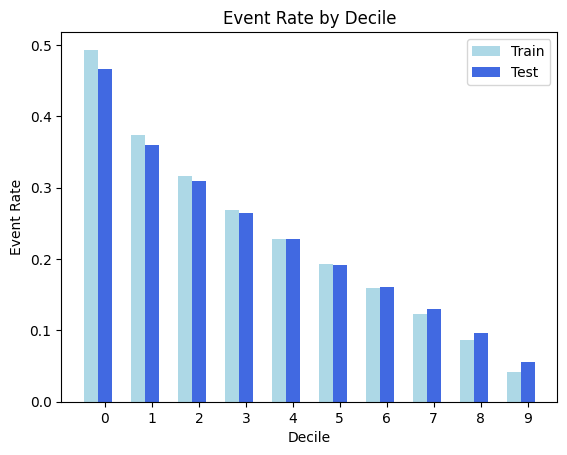

In [ ]:
# Plotando o gráfico de barras para Event Rate por Decil
barWidth = 0.3
r1 = np.arange(len(summary))
r2 = [x + barWidth for x in r1]

plt.bar(r1, summary['event_rate_train'], color='lightblue', width=barWidth, label='Train')
plt.bar(r2, summary['event_rate_test'], color='royalblue', width=barWidth, label='Test')

plt.xlabel('Decile')
plt.ylabel('Event Rate')
plt.title('Event Rate by Decile')
plt.xticks([r + barWidth for r in range(len(summary))], summary['decile'])
plt.legend()
plt.show()

Insight final:
- O Modelo é ligeiramente menos estável que o modelo 2 pois a diferença entre a barra de treino e teste em cada decil é um pouco maior que a do modelo anterior.A diferença entre KS treino e KS teste também é ligeiramente maior.
- O Modelo tem uma performance muito parecida com o modelo anterior analisando % de inadimplentes em relação ao total existente na base nos e % de inadimplentes dentro de cada decil se analisarmos os primeiros decis.
- O Modelo aumentou ligeiramente em 0.002 o KS indo de 0.284071 para 0.285950.
- Devido limitação de poder computacional se utilizou 10 features na etapa de seleção de variáveis, talvez com mais variáveis a performance aumente.
- Mesmo com o aumento de KS ainda é considerando um valor ruim perto do benchmarking de mercado e também está inferior ao modelo atual da claro(KS=33.1) o que indica que existe oportunidade de melhoria.

## Salvar melhor modelo

In [ ]:
#salvando pickle do modelo para futura utilização. (teria que salvar pickles das etapas anteriores de pre-processamento de dados correto?)
import pickle

with open('vars_lgbm_3.pkl', 'wb') as f:
    pickle.dump(X_train_processed.columns, f)

with open('lgbm_3.pkl', 'wb') as file:
  pickle.dump(algoritmo, file)